Import library

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

Read File CSV

In [119]:
df = pd.read_csv("auto-mpg.csv")

Convert horsepower karena ada yang non integer

In [120]:
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

Handle Missing Value/Duplikat

In [121]:
df.isnull().sum()
df = df.dropna()
print("Total missing:", df.isnull().sum())
df.duplicated().sum()
df = df.drop_duplicates()
print("Jumlah duplikat:", df.duplicated().sum())

Total missing: mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64
Jumlah duplikat: 0


Tes Outlier

In [122]:
# Mengambil kolom numerik
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Hitung berapa banyak outlier
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = len(outliers)

print("Jumlah outlier per kolom numerik:")
for k, v in outlier_summary.items():
    print(f"{k}: {v} data")

Jumlah outlier per kolom numerik:
mpg: 0 data
cylinders: 0 data
displacement: 0 data
horsepower: 10 data
weight: 0 data
acceleration: 11 data
model year: 0 data
origin: 0 data


Tes head

In [123]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Feature Engineering

In [124]:
#Rasio Kekuatan ke berat mobil
df['power_to_weight'] = df['horsepower'] / df['weight']

# Kapasitas mesin per silinder
df['displacement_per_cyl'] = df['displacement'] / df['cylinders']

#Rasio jumlah silinder dengan kapasitas mesin
df['cylinder_to_displacement'] = df['cylinders'] / df['displacement']

print(df[['horsepower', 'acceleration', 'weight', 'power_to_weight','displacement_per_cyl', 'cylinder_to_displacement']].head())

   horsepower  acceleration  weight  power_to_weight  displacement_per_cyl  \
0       130.0          12.0    3504         0.037100                38.375   
1       165.0          11.5    3693         0.044679                43.750   
2       150.0          11.0    3436         0.043655                39.750   
3       150.0          12.0    3433         0.043694                38.000   
4       140.0          10.5    3449         0.040591                37.750   

   cylinder_to_displacement  
0                  0.026059  
1                  0.022857  
2                  0.025157  
3                  0.026316  
4                  0.026490  


Rata-rata, standar deviasi, nilai minimum, nilai maksimum, Q1, Q2, dan Q3 dari attribute bertipe angka

In [125]:
numeric_df = df.select_dtypes(include='number')

desc_stats = numeric_df.describe().T
desc_stats["Q1"] = numeric_df.quantile(0.25)
desc_stats["Q2"] = numeric_df.quantile(0.50)
desc_stats["Q3"] = numeric_df.quantile(0.75)

print(desc_stats)

                          count         mean         std          min  \
mpg                       392.0    23.445918    7.805007     9.000000   
cylinders                 392.0     5.471939    1.705783     3.000000   
displacement              392.0   194.411990  104.644004    68.000000   
horsepower                392.0   104.469388   38.491160    46.000000   
weight                    392.0  2977.584184  849.402560  1613.000000   
acceleration              392.0    15.541327    2.758864     8.000000   
model year                392.0    75.979592    3.683737    70.000000   
origin                    392.0     1.576531    0.805518     1.000000   
power_to_weight           392.0     0.034833    0.005935     0.020557   
displacement_per_cyl      392.0    33.424639    8.706997    17.000000   
cylinder_to_displacement  392.0     0.032076    0.008628     0.017582   

                                  25%          50%          75%          max  \
mpg                         17.000000    22

10 record pertama dari dataset dengan attribute bertipe angka

In [126]:
print("\n10 Data Numerik:\n", df.select_dtypes(include=np.number).head(10))


10 Data Numerik:
     mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   
5  15.0          8         429.0       198.0    4341          10.0   
6  14.0          8         454.0       220.0    4354           9.0   
7  14.0          8         440.0       215.0    4312           8.5   
8  14.0          8         455.0       225.0    4425          10.0   
9  15.0          8         390.0       190.0    3850           8.5   

   model year  origin  power_to_weight  displacement_per_cyl  \
0          70       1         0.037100                38.375   
1          70       1         0.044679                43.750   
2          70     

Informasi jumlah record, jumlah attribute, nama attribute, jumlah attribute dengan tipe angka

In [127]:
print("\nDataset info:")
print("Number of records:", df.shape[0])
print("Number of attributes:", df.shape[1])
print("Attribute names:", df.columns.tolist())
print("Number of numeric attributes:", df.select_dtypes(include=np.number).shape[1])


Dataset info:
Number of records: 392
Number of attributes: 12
Attribute names: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name', 'power_to_weight', 'displacement_per_cyl', 'cylinder_to_displacement']
Number of numeric attributes: 11


Jumlah label dari semua attribute yang bernilai object.

In [128]:
object_columns = df.select_dtypes(include='object').columns
for col in object_columns:
    print(f"Unique labels in {col}: {df[col].nunique()}")

Unique labels in car name: 301


Diagram batang

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14000\4024146928.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cylinders', y='mpg', data=mpg_by_cyl, palette="viridis")


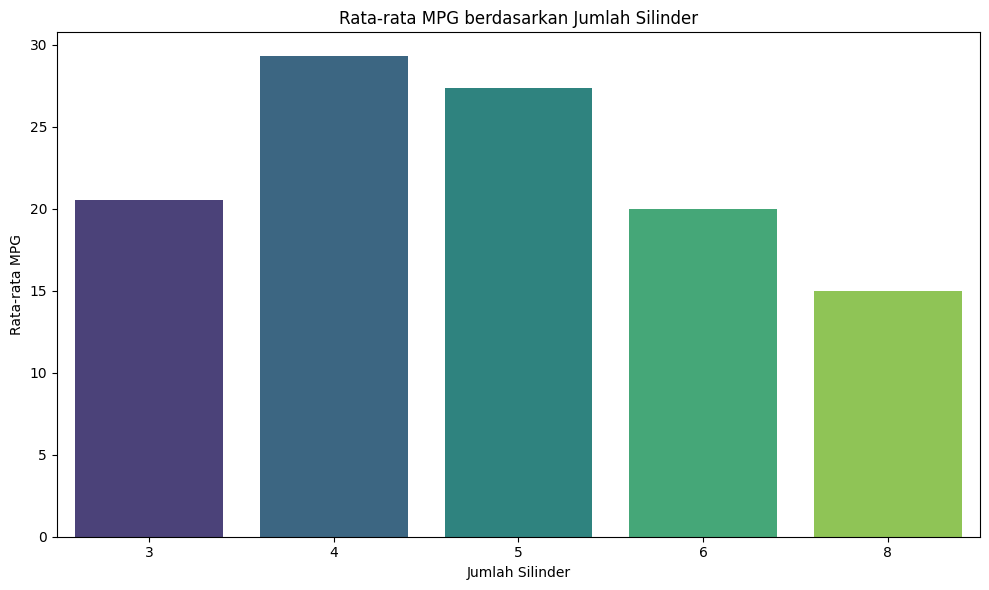

In [129]:
mpg_by_cyl = df.groupby('cylinders')['mpg'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='cylinders', y='mpg', data=mpg_by_cyl, palette="viridis")
plt.title('Rata-rata MPG berdasarkan Jumlah Silinder')
plt.xlabel('Jumlah Silinder')
plt.ylabel('Rata-rata MPG')
plt.tight_layout()
plt.show()

Heatmap

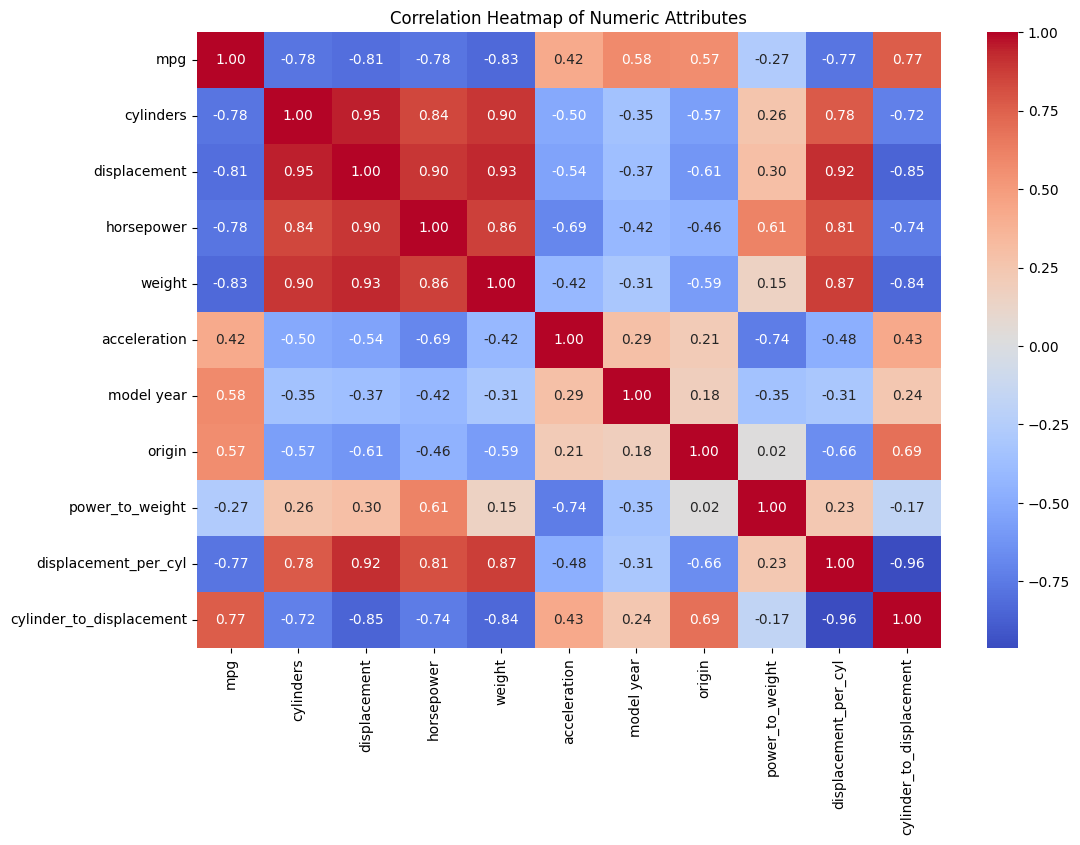

In [130]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Attributes')
plt.show()

Analisis dan kesimpulan
-Nilai MPG (Miles per Gallon) bervariasi tergantung jumlah silinder.  
-Kendaraan dengan jumlah silinder lebih sedikit cenderung memiliki MPG lebih tinggi, menunjukkan efisiensi bahan bakar lebih baik.
-Beberapa atribut seperti `displacement` dan `horsepower` juga berpengaruh terhadap MPG.
-Jumlah kendaraan dengan 4 silinder paling banyak dibandingkan dengan yang 6 atau 8 silinder.  
-Visualisasi batang menunjukkan tren jelas bahwa kendaraan dengan lebih banyak silinder umumnya lebih boros bahan bakar.

Encoding Kolom Kategorikal

In [131]:
df = pd.get_dummies(df, columns=['origin'])
print(df.head(30))

     mpg  cylinders  displacement  horsepower  weight  acceleration  \
0   18.0          8         307.0       130.0    3504          12.0   
1   15.0          8         350.0       165.0    3693          11.5   
2   18.0          8         318.0       150.0    3436          11.0   
3   16.0          8         304.0       150.0    3433          12.0   
4   17.0          8         302.0       140.0    3449          10.5   
5   15.0          8         429.0       198.0    4341          10.0   
6   14.0          8         454.0       220.0    4354           9.0   
7   14.0          8         440.0       215.0    4312           8.5   
8   14.0          8         455.0       225.0    4425          10.0   
9   15.0          8         390.0       190.0    3850           8.5   
10  15.0          8         383.0       170.0    3563          10.0   
11  14.0          8         340.0       160.0    3609           8.0   
12  15.0          8         400.0       150.0    3761           9.5   
13  14

Menentukan fitur apa yang dipakai dan target yang diprediksi

In [132]:
X = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']]
y = df['mpg']

Split data

In [133]:
X = df[['displacement','horsepower','weight','acceleration']]
y = df['mpg']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Jumlah data total:", len(df))
print("Training set:", len(X_train))
print("Testing set:", len(X_test))

Jumlah data total: 392
Training set: 313
Testing set: 79


Normalisasi Kolom Numerik

In [134]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Membuat dan Melatih model (Linear Regression)

In [135]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluasi Model (MAE/MSE/RMSE/R2-Score)

In [136]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n Evaluasi {model_name}:")
    print(f"MAE  : {mae:.3f}")
    print(f"MSE  : {mse:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R²   : {r2:.3f}")

# Evaluasi keduanya
evaluate_model(y_test, y_pred, "Linear Regression")


 Evaluasi Linear Regression:
MAE  : 3.510
MSE  : 18.066
RMSE : 4.250
R²   : 0.646


Plot hasil Prediksi dan nilai asli

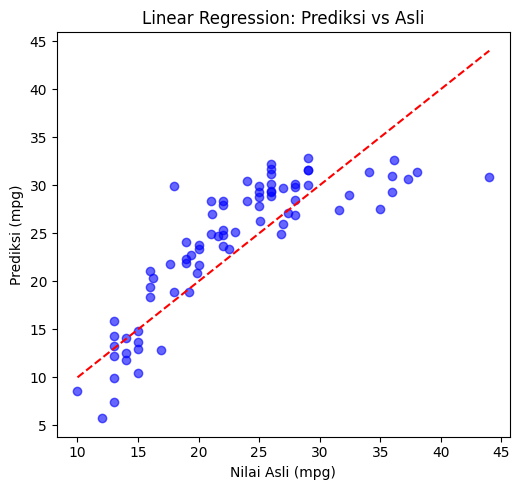

In [137]:
plt.figure(figsize=(10,5))

# Plot Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Prediksi vs Asli')
plt.xlabel('Nilai Asli (mpg)')
plt.ylabel('Prediksi (mpg)')

plt.tight_layout()
plt.show()

tes fitur ngaruh atau tidak

In [138]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)
print(coef_df)

        Feature  Coefficient
2        weight    -0.005023
0  displacement    -0.009351
1    horsepower    -0.048472
3  acceleration    -0.059428


mencari parameter terbaik untuk svr

In [145]:
param_grid = {
    'C': [1, 10, 50, 100],
    'gamma': [0.01, 0.1, 0.5, 1],
    'epsilon': [0.05, 0.1, 0.2]
}

grid = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_svr = grid.best_estimator_
y_pred_best = best_svr.predict(X_test_scaled)

r2_best = r2_score(y_test, y_pred_best)
print(f"R² on Test Data: {r2_best:.3f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 100, 'epsilon': 0.05, 'gamma': 0.1}
Best CV R²: 0.7579605910600746
R² on Test Data: 0.670


Inisialisasi Model (SVR)

In [151]:
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.05)

Latih model SVR

In [153]:
svr.fit(X_train_scaled, y_train)

,kernel,'rbf'
,degree,3
,gamma,0.1
,coef0,0.0
,tol,0.001
,C,100
,epsilon,0.05
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


Prediksi

In [154]:
y_pred_svr = svr.predict(X_test_scaled)

Evaluasi SVR

In [155]:
mae = mean_absolute_error(y_test, y_pred_svr)
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_svr)

print(f"Evaluasi Support Vector Regressor (RBF Kernel):")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

Evaluasi Support Vector Regressor (RBF Kernel):
MAE  : 2.840
MSE  : 16.835
RMSE : 4.103
R²   : 0.670


Plot Hasil Prediksi dari SVR

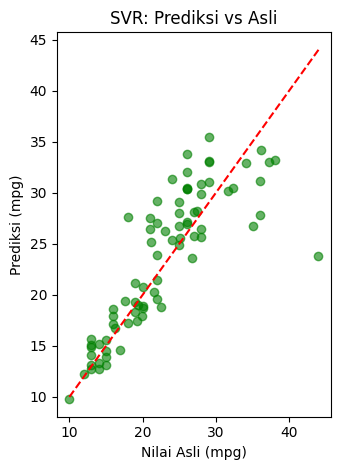

In [156]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_svr, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('SVR: Prediksi vs Asli')
plt.xlabel('Nilai Asli (mpg)')
plt.ylabel('Prediksi (mpg)')

plt.tight_layout()
plt.show()

Penjelasan dari linear vs SVR

Berdasarkanhasil evaluasi, model Linear Regression menghasilkan nilai MAE sebesar 3.51, MSE sebesar 18.06, RMSE sebesar 4.25, dan R² sebesar 0.646, yang berarti prediksi model menyimpang 3.5 dan model mampu menjelaskan sekitar 64.6% variasi dalam data.
Sedangkan SVR, menghasilkan nilai MAE sebesar 2.84, MSE sebesar 16.835, RMSE sebesar 4.103, dan R² sebesar 0.670, yang dimana berarti SVR lebih akurat dibandingkan dengan Linear Regression